# Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.style.use("fast")
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import random
import statistics

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

!pip install -q pyfim
from fim import apriori
from fim import fpgrowth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
print(pd.__version__)

1.5.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset encoded but not scaled.

In [ ]:
datasetPath = '/content/drive/MyDrive/UNIPI/DM1/DATASET: Spotify/DM1 - Project/files/dm1_df_understanding_NOTSCALED.csv'
data = pd.read_csv(datasetPath)

data.head(3)

,name,explicit,popularity,artists,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_bars,processing,genre,duration_min
0,0,0,46,0,0,0.690,0.513,5,-12.529,1,0.0975,0.302000,0.536,0.281,0.6350,142.221,141.0,1.279305,0,4.029333
1,1,0,0,1,1,0.069,0.196,1,-24.801,0,0.0805,0.283000,0.934,0.360,0.0336,75.596,155.0,2.367412,1,7.400000
2,2,0,3,2,2,0.363,0.854,2,-7.445,0,0.0397,0.000089,0.800,0.262,0.4890,116.628,162.0,3.700483,2,5.558433


In order to easily map object variables to the integers with which they were replaced (we are talking about `name`, `artists`, `album_name`, and `genre`), we decided to save to disk a dictionary of dictionaries, containing each integer associated with the original string. This way we can see what `genre` each integer in the genre column is associated with.

In [ ]:
import pickle

# Carica il dizionario inverso da disco
with open('/content/drive/MyDrive/UNIPI/DM1/DATASET: Spotify/DM1 - Project/files/inverse_column_dicts.pkl', 'rb') as f:
    loaded_inverse_column_dicts = pickle.load(f)

genre_dict = loaded_inverse_column_dicts['genre']
genre_dict

{0: 'j-dance',
 1: 'iranian',
 2: 'black-metal',
 3: 'bluegrass',
 4: 'happy',
 5: 'industrial',
 6: 'j-idol',
 7: 'spanish',
 8: 'sleep',
 9: 'techno',
 10: 'mandopop',
 11: 'afrobeat',
 12: 'disney',
 13: 'study',
 14: 'indian',
 15: 'idm',
 16: 'forro',
 17: 'chicago-house',
 18: 'brazil',
 19: 'breakbeat'}

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
name,15000.0,7499.500000,4330.271354,0.000000,3749.750000,7499.500000,11249.250000,14999.000000
explicit,15000.0,0.064400,0.245472,0.000000,0.000000,0.000000,0.000000,1.000000
popularity,15000.0,27.423667,18.587534,0.000000,14.000000,24.000000,42.000000,94.000000
artists,15000.0,1987.648467,1755.410934,0.000000,486.000000,1437.000000,3178.000000,6256.000000
album_name,15000.0,4084.496400,2832.826566,0.000000,1569.750000,3673.000000,6399.000000,9819.000000
danceability,15000.0,0.551063,0.194239,0.000000,0.441000,0.580000,0.695000,0.980000
energy,15000.0,0.656231,0.264371,0.000000,0.480000,0.709000,0.884000,1.000000
key,15000.0,5.287867,3.585023,0.000000,2.000000,5.000000,8.000000,11.000000
loudness,15000.0,-8.894999,6.005799,-49.531000,-10.636250,-7.303000,-5.101000,3.156000
mode,15000.0,0.628400,0.483248,0.000000,0.000000,1.000000,1.000000,1.000000


In [ ]:
df = data.copy(deep=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              15000 non-null  int64  
 1   explicit          15000 non-null  int64  
 2   popularity        15000 non-null  int64  
 3   artists           15000 non-null  int64  
 4   album_name        15000 non-null  int64  
 5   danceability      15000 non-null  float64
 6   energy            15000 non-null  float64
 7   key               15000 non-null  int64  
 8   loudness          15000 non-null  float64
 9   mode              15000 non-null  int64  
 10  speechiness       15000 non-null  float64
 11  acousticness      15000 non-null  float64
 12  instrumentalness  15000 non-null  float64
 13  liveness          15000 non-null  float64
 14  valence           15000 non-null  float64
 15  tempo             15000 non-null  float64
 16  n_bars            15000 non-null  float6

In [ ]:
df.drop(['name','artists', 'album_name'], axis=1, inplace=True)

In [ ]:
df.head()

,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_bars,processing,genre,duration_min
0,0,46,0.690,0.513,5,-12.529,1,0.0975,0.302000,0.53600,0.281,0.6350,142.221,141.0,1.279305,0,4.029333
1,0,0,0.069,0.196,1,-24.801,0,0.0805,0.283000,0.93400,0.360,0.0336,75.596,155.0,2.367412,1,7.400000
2,0,3,0.363,0.854,2,-7.445,0,0.0397,0.000089,0.80000,0.262,0.4890,116.628,162.0,3.700483,2,5.558433
3,0,23,0.523,0.585,5,-5.607,1,0.0765,0.066400,0.00127,0.117,0.3850,140.880,155.0,1.279305,3,4.496667
4,0,25,0.643,0.687,7,-11.340,1,0.0539,0.000576,0.09690,0.299,0.6370,143.956,183.0,4.067086,4,5.127517


In [ ]:
df.shape

(15000, 17)

### TEST SET

In [ ]:
testSetPath = '/content/drive/MyDrive/UNIPI/DM1/DATASET: Spotify/DM1 - Project/files/test.csv'
test_df = pd.read_csv(testSetPath)

test_df.head(3)

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Untrue,206826,False,32,Coal Chamber,Chamber Music,0.383,0.951,0,-3.743,...,0.2610,0.668,110.584,206827,4.0,385.0,96.0,NaN,3.349057,industrial
1,High Roller,329733,False,41,The Crystal Method,Vegas,0.464,0.579,5,-9.136,...,0.0992,0.140,171.752,329733,4.0,935.0,235.0,NaN,1.279305,breakbeat
2,Na Tum Jano Na Hum (ReVibe),136000,False,40,Ashwin Adwani,Na Tum Jano Na Hum (ReVibe),0.611,0.778,9,-4.803,...,0.1390,0.285,90.024,136000,4.0,200.0,49.0,NaN,1.343558,indian


In [ ]:
# Pre-Processing
test_df.drop(['name','artists', 'album_name','time_signature','popularity_confidence','features_duration_ms','n_beats'], axis=1, inplace=True)
test_df['duration_min'] = test_df['duration_ms'] / 60000
test_df.drop('duration_ms', axis=1, inplace=True)
test_df['explicit'] = [int(x) for x in test_df['explicit']] # bool->int (binary)
test_df['key'] = [int(x) for x in test_df['key']] # float -> int

data_modeNoNull = test_df.dropna(subset=['mode'], axis=0)
mode_1_records = test_df[test_df['mode'] == 1].shape[0]
mode_0_records = test_df[test_df['mode'] == 0].shape[0]
percent_1 = mode_1_records / data_modeNoNull.shape[0]
percent_0 = mode_0_records / data_modeNoNull.shape[0]
null_count_mode = test_df['mode'].isnull().sum()
count_1 = int(null_count_mode * (percent_1 / 100))
count_0 = null_count_mode - count_1
random_values = np.random.choice([1, 0], size=null_count_mode, p=[percent_1, percent_0])
test_df.loc[test_df['mode'].isnull(), 'mode'] = random_values
test_df['mode'] = [int(x) for x in test_df['mode']] # float->int (binary)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   explicit          5000 non-null   int64  
 1   popularity        5000 non-null   int64  
 2   danceability      5000 non-null   float64
 3   energy            5000 non-null   float64
 4   key               5000 non-null   int64  
 5   loudness          5000 non-null   float64
 6   mode              5000 non-null   int64  
 7   speechiness       5000 non-null   float64
 8   acousticness      5000 non-null   float64
 9   instrumentalness  5000 non-null   float64
 10  liveness          5000 non-null   float64
 11  valence           5000 non-null   float64
 12  tempo             5000 non-null   float64
 13  n_bars            5000 non-null   float64
 14  processing        5000 non-null   float64
 15  genre             5000 non-null   object 
 16  duration_min      5000 non-null   float64


In [ ]:
# Ottieni i generi nel training set
train_genres = set(genre_dict.values())

# Ottieni i generi unici nel test set
test_genres = set(test_df['genre'].unique())

# Confronta i generi
common_genres = train_genres.intersection(test_genres)
train_only_genres = train_genres.difference(test_genres)
test_only_genres = test_genres.difference(train_genres)

print("Generi comuni:", common_genres)
print("Generi solo nel training set:", train_only_genres)
print("Generi solo nel test set:", test_only_genres)

Generi comuni: {'forro', 'disney', 'bluegrass', 'j-dance', 'study', 'j-idol', 'idm', 'spanish', 'techno', 'breakbeat', 'sleep', 'mandopop', 'chicago-house', 'indian', 'black-metal', 'industrial', 'brazil', 'happy', 'afrobeat', 'iranian'}
Generi solo nel training set: set()
Generi solo nel test set: set()


In [ ]:
# Inverti il dizionario
genre_dict_test = {v: k for k, v in genre_dict.items()}
# Ora mappa i generi del test set agli interi corrispondenti
test_df['genre'] = test_df['genre'].map(genre_dict_test)

In [ ]:
test_df = pd.get_dummies(test_df, columns=['key'])
print(test_df.shape, df.shape)
test_df.head()

(5000, 28) (15000, 17)


,explicit,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,0,32,0.383,0.951,-3.743,1,0.1040,0.00607,0.000000,0.2610,...,0,0,0,0,0,0,0,0,0,0
1,0,41,0.464,0.579,-9.136,1,0.0596,0.28100,0.827000,0.0992,...,0,0,0,1,0,0,0,0,0,0
2,0,40,0.611,0.778,-4.803,1,0.0326,0.09460,0.000005,0.1390,...,0,0,0,0,0,0,0,1,0,0
3,0,25,0.500,0.958,-1.695,0,0.0350,0.00817,0.318000,0.7320,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.802,0.684,-8.839,1,0.1230,0.00181,0.010200,0.2360,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   explicit          15000 non-null  int64  
 1   popularity        15000 non-null  int64  
 2   danceability      15000 non-null  float64
 3   energy            15000 non-null  float64
 4   key               15000 non-null  int64  
 5   loudness          15000 non-null  float64
 6   mode              15000 non-null  int64  
 7   speechiness       15000 non-null  float64
 8   acousticness      15000 non-null  float64
 9   instrumentalness  15000 non-null  float64
 10  liveness          15000 non-null  float64
 11  valence           15000 non-null  float64
 12  tempo             15000 non-null  float64
 13  n_bars            15000 non-null  float64
 14  processing        15000 non-null  float64
 15  genre             15000 non-null  int64  
 16  duration_min      15000 non-null  float6

Pattern mining can be used to achieve various analysis goals or business objectives. Here are some possibilities related to our dataset:

- Music Recommendation: By identifying patterns in user listening habits, you could recommend songs that match their taste. For example, if a user frequently listens to songs with high danceability and energy, you could recommend similar songs.

- Artist Popularity Analysis: You could analyze the popularity attribute in conjunction with other attributes to understand what factors contribute to an artist’s popularity.

- Genre Classification: By identifying patterns in song attributes, you could predict the genre of a song. This could be useful for categorizing songs in a music library.

- Music Trend Analysis: You could identify trends in music over time. For example, you might find that songs with high acousticness and low energy are becoming more popular.

Explicit Content Analysis: You could analyze the explicit attribute in relation to other attributes to understand the characteristics of songs with explicit content.

# PATTERN MINING

### Pre-processing

In [ ]:
df_pm = df.copy(deep=True)
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   explicit          15000 non-null  int64  
 1   popularity        15000 non-null  int64  
 2   danceability      15000 non-null  float64
 3   energy            15000 non-null  float64
 4   key               15000 non-null  int64  
 5   loudness          15000 non-null  float64
 6   mode              15000 non-null  int64  
 7   speechiness       15000 non-null  float64
 8   acousticness      15000 non-null  float64
 9   instrumentalness  15000 non-null  float64
 10  liveness          15000 non-null  float64
 11  valence           15000 non-null  float64
 12  tempo             15000 non-null  float64
 13  n_bars            15000 non-null  float64
 14  processing        15000 non-null  float64
 15  genre             15000 non-null  int64  
 16  duration_min      15000 non-null  float6

In [ ]:
# Mapping categorical features

explicit_dict = {0: "Non-Explicit", 1: "Explicit"}
df_pm["explicit"] = df_pm["explicit"].map(explicit_dict)

key_dict = {0: "C",
            1: "C#/Db",
            2: "D",
            3: "D#/Eb",
            4: "E",
            5: "F",
            6: "F#/Gb",
            7: "G",
            8: "G#/Ab",
            9: "A",
            10: "A#/Bb",
            11: "B"
            } # pitch class notation
df_pm["key"] = df_pm["key"].map(key_dict)

mode_dict = {0: "Minor", 1: "Major"}
df_pm["mode"] = df_pm["mode"].map(mode_dict)

df_pm["genre"] = df_pm["genre"].map(genre_dict)

In [ ]:
# Columns
cols_to_bin = ['popularity', 'danceability', 'energy', 'loudness',
               'speechiness', 'acousticness', 'instrumentalness',
               'liveness', 'valence', 'tempo', 'n_bars', 'processing', 'duration_min']

# Number of bins
n_bins = 3 #low, medium, high
labels = ["Low", "Medium", "High"]

for col in cols_to_bin:
    df_pm[col] = pd.cut(df_pm[col], bins=n_bins, labels=labels)
    df_pm[col] = df_pm[col].astype(str) + f"_{col}"


df_pm.head()

,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_bars,processing,genre,duration_min
0,Non-Explicit,Medium_popularity,High_danceability,Medium_energy,F,High_loudness,Major,Low_speechiness,Low_acousticness,Medium_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,Low_processing,j-dance,Low_duration_min
1,Non-Explicit,Low_popularity,Low_danceability,Low_energy,C#/Db,Medium_loudness,Minor,Low_speechiness,Low_acousticness,High_instrumentalness,Medium_liveness,Low_valence,Medium_tempo,Low_n_bars,Medium_processing,iranian,Low_duration_min
2,Non-Explicit,Low_popularity,Medium_danceability,High_energy,D,High_loudness,Minor,Low_speechiness,Low_acousticness,High_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,High_processing,black-metal,Low_duration_min
3,Non-Explicit,Low_popularity,Medium_danceability,Medium_energy,F,High_loudness,Major,Low_speechiness,Low_acousticness,Low_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,Low_processing,bluegrass,Low_duration_min
4,Non-Explicit,Low_popularity,Medium_danceability,High_energy,G,High_loudness,Major,Low_speechiness,Low_acousticness,Low_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,High_processing,happy,Low_duration_min


In [ ]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   explicit          15000 non-null  object
 1   popularity        15000 non-null  object
 2   danceability      15000 non-null  object
 3   energy            15000 non-null  object
 4   key               15000 non-null  object
 5   loudness          15000 non-null  object
 6   mode              15000 non-null  object
 7   speechiness       15000 non-null  object
 8   acousticness      15000 non-null  object
 9   instrumentalness  15000 non-null  object
 10  liveness          15000 non-null  object
 11  valence           15000 non-null  object
 12  tempo             15000 non-null  object
 13  n_bars            15000 non-null  object
 14  processing        15000 non-null  object
 15  genre             15000 non-null  object
 16  duration_min      15000 non-null  object
dtypes: object(17

In [ ]:
df_pm.head()

,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,n_bars,processing,genre,duration_min
0,Non-Explicit,Medium_popularity,High_danceability,Medium_energy,F,High_loudness,Major,Low_speechiness,Low_acousticness,Medium_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,Low_processing,j-dance,Low_duration_min
1,Non-Explicit,Low_popularity,Low_danceability,Low_energy,C#/Db,Medium_loudness,Minor,Low_speechiness,Low_acousticness,High_instrumentalness,Medium_liveness,Low_valence,Medium_tempo,Low_n_bars,Medium_processing,iranian,Low_duration_min
2,Non-Explicit,Low_popularity,Medium_danceability,High_energy,D,High_loudness,Minor,Low_speechiness,Low_acousticness,High_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,High_processing,black-metal,Low_duration_min
3,Non-Explicit,Low_popularity,Medium_danceability,Medium_energy,F,High_loudness,Major,Low_speechiness,Low_acousticness,Low_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,Low_processing,bluegrass,Low_duration_min
4,Non-Explicit,Low_popularity,Medium_danceability,High_energy,G,High_loudness,Major,Low_speechiness,Low_acousticness,Low_instrumentalness,Low_liveness,Medium_valence,Medium_tempo,Low_n_bars,High_processing,happy,Low_duration_min


In [ ]:
for col in cols_to_bin:
  print(df_pm[col].unique())

['Medium_popularity' 'Low_popularity' 'High_popularity']
['High_danceability' 'Low_danceability' 'Medium_danceability']
['Medium_energy' 'Low_energy' 'High_energy']
['High_loudness' 'Medium_loudness' 'Low_loudness']
['Low_speechiness' 'Medium_speechiness' 'High_speechiness']
['Low_acousticness' 'High_acousticness' 'Medium_acousticness']
['Medium_instrumentalness' 'High_instrumentalness' 'Low_instrumentalness']
['Low_liveness' 'Medium_liveness' 'High_liveness']
['Medium_valence' 'Low_valence' 'High_valence']
['Medium_tempo' 'High_tempo' 'Low_tempo']
['Low_n_bars' 'Medium_n_bars' 'High_n_bars']
['Low_processing' 'Medium_processing' 'High_processing']
['Low_duration_min' 'Medium_duration_min' 'High_duration_min']


In [ ]:
X = df_pm.values.tolist()
X[:2]

[['Non-Explicit',
  'Medium_popularity',
  'High_danceability',
  'Medium_energy',
  'F',
  'High_loudness',
  'Major',
  'Low_speechiness',
  'Low_acousticness',
  'Medium_instrumentalness',
  'Low_liveness',
  'Medium_valence',
  'Medium_tempo',
  'Low_n_bars',
  'Low_processing',
  'j-dance',
  'Low_duration_min'],
 ['Non-Explicit',
  'Low_popularity',
  'Low_danceability',
  'Low_energy',
  'C#/Db',
  'Medium_loudness',
  'Minor',
  'Low_speechiness',
  'Low_acousticness',
  'High_instrumentalness',
  'Medium_liveness',
  'Low_valence',
  'Medium_tempo',
  'Low_n_bars',
  'Medium_processing',
  'iranian',
  'Low_duration_min']]

## APRIORI

In [ ]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

- frequent itemset >= min_supp
- closed: an itemset is closed if none of its immediate supersets has the same support as the itemset
- maximal: an itemset is maximal frequent if none of its immediate supersets is frequent

In [ ]:
%%time
#18sec

# Define the parameter grid
supp_values = np.linspace(10, 50, 5)
zmin_values = np.arange(5, df_pm.shape[1])

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=["supp", "zmin", "num_frequent_itemsets",
                                "num_closed_itemsets", "num_maximal_itemsets"])

# Loop over the parameter grid
for supp in tqdm(supp_values):
    for zmin in zmin_values:
        # Run Apriori for each type of itemset
        frequent_itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S")
        closed_itemsets = apriori(X, target="c", supp=supp, zmin=zmin, report="S")
        maximal_itemsets = apriori(X, target="m", supp=supp, zmin=zmin, report="S")

        # Compute some evaluation metric (in this case, the number of itemsets)
        num_frequent = len(frequent_itemsets)
        num_closed = len(closed_itemsets)
        num_maximal = len(maximal_itemsets)

        # Store the results
        results = pd.concat([results, pd.DataFrame([{"supp": supp, "zmin": zmin, "num_frequent_itemsets": num_frequent,
                                                     "num_closed_itemsets": num_closed, "num_maximal_itemsets": num_maximal}])],
                            ignore_index=True)

# Sort the results based on some criteria
results = results.sort_values(by=["num_frequent_itemsets", "num_closed_itemsets", "num_maximal_itemsets"], ascending=False)

# Print the best parameters
best_parameters = results.iloc[0]
print(f"Best parameters: supp={best_parameters['supp']}, zmin={best_parameters['zmin']}")

  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters: supp=10.0, zmin=5
CPU times: user 16.7 s, sys: 13.8 ms, total: 16.7 s
Wall time: 16.9 s


In [ ]:
supp = best_parameters['supp']
zmin = best_parameters['zmin']

print(supp, zmin)

10.0 5


### Frequent Itemset

In [ ]:
itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"]).sort_values(by="support", axis=0, ascending=False)

,frequent_itemset,support
18884,"(High_loudness, Non-Explicit, Low_speechiness,...",78.400000
18883,"(Low_liveness, Non-Explicit, Low_speechiness, ...",74.126667
18877,"(Medium_tempo, Non-Explicit, Low_speechiness, ...",68.440000
18882,"(Low_liveness, High_loudness, Low_speechiness,...",67.973333
18881,"(Low_liveness, High_loudness, Non-Explicit, Lo...",65.580000
...,...,...
427,"(High_tempo, Low_popularity, Low_liveness, Non...",10.000000
2064,"(Medium_energy, Low_processing, Low_instrument...",10.000000
2063,"(Medium_energy, Low_processing, Low_instrument...",10.000000
5717,"(Medium_valence, Low_processing, Medium_dancea...",10.000000


Each row represents a frequent itemset, which is a set of items that appear together in your dataset more frequently than a certain threshold (defined by the supp parameter). The frequent_itemset column lists the items in each itemset. The items seem to be ranges of values for different features in your data, such as duration_min, n_bars, and speechiness. There’s also a categorical feature Non-Explicit. The support column shows the support of each itemset, which is the proportion of transactions in your dataset that contain the itemset. It’s a measure of how frequently the itemset appears in the dataset.

By setting 2, 3 or 4 as the minimum of the `zmin` range, we realized that the patterns found were just a simple confirmation of some information already found in data understanding: in fact in the dataset most of the traces have a fairly short duration (the distribution is positively skewed). By setting a value of zmin equal to 5 instead, we can already begin to get more useful patterns.

We can see that our dataset predominantly consists of non-explicit tracks with high volume, low speechiness, a duration range that remains below 22 minutes, and a low number of bars. Tracks with medium tempo, low speechiness, a similar duration range, and a similar number of bars also have a significant presence. The presence of liveness feature among the most frequent patterns also suggests that dataset contains lots of tracks that have a low “live” feel.

### Closed Itemset

In [ ]:
itemsets = apriori(X, target="c", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["closed_itemset", "support"]).sort_values(by="support", axis=0, ascending=False)

,closed_itemset,support
8574,"(High_loudness, Non-Explicit, Low_speechiness,...",78.400000
8573,"(Low_liveness, Non-Explicit, Low_speechiness, ...",74.126667
8569,"(Medium_tempo, Non-Explicit, Low_speechiness, ...",68.440000
8572,"(Low_liveness, High_loudness, Low_speechiness,...",67.973333
8571,"(Low_liveness, High_loudness, Non-Explicit, Lo...",65.580000
...,...,...
2322,"(Medium_valence, Low_processing, Medium_dancea...",10.000000
1911,"(High_danceability, High_energy, Low_popularit...",10.000000
3642,"(Minor, Low_processing, Low_popularity, Low_ac...",10.000000
5298,"(Low_processing, High_energy, Low_acousticness...",10.000000


### Maximal itemsets

In [ ]:
itemsets = apriori(X, target="m", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["maximal_itemset", "support"]).sort_values(by="support", axis=0, ascending=False)

,maximal_itemset,support
586,"(Low_processing, Low_instrumentalness, Medium_...",16.713333
629,"(High_energy, Low_popularity, Low_acousticness...",15.853333
638,"(High_energy, Low_acousticness, Low_instrument...",14.653333
637,"(High_energy, Low_acousticness, Major, Medium_...",13.806667
410,"(Medium_popularity, Low_instrumentalness, Medi...",13.746667
...,...,...
48,"(High_tempo, Medium_danceability, Low_instrume...",10.000000
356,"(Medium_valence, Low_popularity, Low_instrumen...",10.000000
313,"(Medium_valence, Low_processing, Medium_dancea...",10.000000
238,"(High_processing, Low_acousticness, Major, Med...",10.000000


### Support Plots

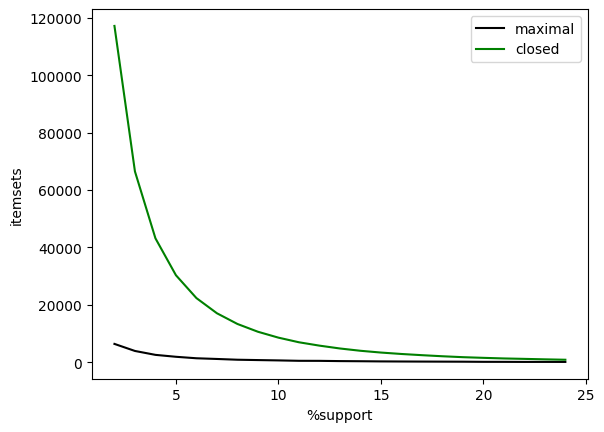

In [ ]:
len_max_it = []
len_cl_it = []
max_supp = 25

for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin)
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))

plt.plot(np.arange(2, max_supp), len_max_it, label="maximal", color='black')
plt.plot(np.arange(2, max_supp), len_cl_it, label="closed", color='green')
plt.legend()
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

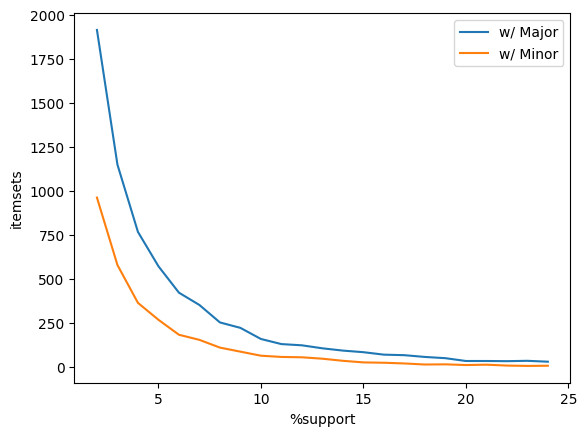

In [ ]:
filter_1 = []
filter_2 = []
for i in range(2, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    filter_1.append(len([item for item in max_itemsets if "Major" in item[0]]))
    filter_2.append(len([item for item in max_itemsets if "Minor" in item[0]]))

plt.plot(np.arange(2, max_supp), filter_1, label="w/ Major")
plt.plot(np.arange(2, max_supp), filter_2, label="w/ Minor")
plt.legend()
plt.xticks()
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()

## RULES

if the target is association rules: a list of rules (i.e. tuples with two or more elements), each consisting of a head/consequent item, a tuple with a body/antecedent item set, and the values selected by the parameter 'report', which may be combined into a tuple or a list if report[0] is '(' or '[', respectively.

Here’s a breakdown of the code:

- `conf = 60`: This sets the minimum confidence for the rules to 60%. Confidence is a measure of the reliability of the rule. A confidence of 60% means that in 60% of the cases where the antecedent is found, the consequent is also found.

- `rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")`: This line runs the Apriori algorithm on the dataset X. The target="r" parameter means that it’s looking for association rules. The supp and zmin are the minimum support and minimum number of items in an itemset, respectively. The report="aScl" parameter means that the algorithm will report the absolute support a, support s, confidence c, and lift l of each rule.

The results are then converted into a DataFrame and sorted by the `lift`. The output is a list of rules with their consequents, antecedents, absolute support, support percentage, confidence, and lift. Lift measures the strength of a rule over the random occurrence of the antecedent and consequent. A lift greater than 1 indicates that the antecedent and consequent are more likely to occur together than just randomly.

For example, the first rule in our output suggests that when the `valence` is in the `range (0.663, 0.995]`, `liveness` is in the `range (-0.000994, 0.331]`, `duration_min` is in the `range (0.0746, 22.986]`, and `n_bars` is in the `range (-2.17, 723.333]`, the `danceability` is likely to be in the range `(0.653, 0.98]`. This rule has an absolute support of 1853, meaning it occurs 1853 times in the dataset. It has a support of 12.35%, a confidence of 60.03%, and a lift of 1.77.

In [ ]:
# Define the range of confidence values to test
conf_values = range(50, 100, 5)

# Initialize a dictionary to store the results
results = {}

# Loop over the confidence values
for conf in tqdm(conf_values):
    # Run the apriori algorithm
    rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")

    # Convert the rules to a DataFrame
    rules_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )

    # Sort the rules by lift
    rules_df = rules_df.sort_values(by="lift", axis=0, ascending=False)

    # Store the rules DataFrame in the results dictionary
    results[conf] = rules_df

# Now, 'results' is a dictionary where the keys are confidence values and the values are the corresponding rules DataFrames
avg_lifts = {}

# Loop over the results
for conf, rules_df in results.items():
    # Calculate the average lift for this confidence level
    avg_lift = rules_df['lift'].mean()

    # Store the average lift in the dictionary
    avg_lifts[conf] = avg_lift

# Find the confidence level with the highest average lift
best_conf = max(avg_lifts, key=avg_lifts.get)

print(f"The best value for conf is {best_conf} with an average lift of {avg_lifts[best_conf]}")

  0%|          | 0/10 [00:00<?, ?it/s]

The best value for conf is 65 with an average lift of 1.0621847787033813


In [ ]:
conf = best_conf
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")

rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)

rules_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
470,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1112,7.413333,0.720674,5.118423
468,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1111,7.406667,0.720493,5.117137
469,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1111,7.406667,0.720026,5.113820
471,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1113,7.420000,0.719922,5.113085
482,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1114,7.426667,0.719638,5.111067
...,...,...,...,...,...,...
15162,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1394,9.293333,0.654460,0.751677
15160,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1374,9.160000,0.653042,0.750048
15154,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1373,9.153333,0.652877,0.749859
15158,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1373,9.153333,0.652877,0.749859


- Consequent: This is the item that appears in the rule’s right-hand side (after the “IF…THEN” statement). In our case, it’s mainly related to `energy` (we are visualizing the dataset ordered by descending lift values).
- Antecedent: These are the items that appear in the rule’s left-hand side (the “IF” part of the “IF…THEN” statement). They are the conditions of the rule. For example, `High_acousticness,Low_valence,Low_liveness,Non-Explicit,Low_speechiness,Low_n_bars` means that if a song has these characteristics then the rule applies.
- abs_support: This is the absolute support, which is the number of transactions that include all items in both the antecedent and consequent. It’s a measure of how frequently the combination occurs in the dataset.
- %_support: This is the relative support, which is the proportion of transactions in the dataset that contain all items in both the antecedent and consequent.
- confidence: This is a measure of how often the rule has been found to be true. For example, a confidence of 0.7206740116655865	 for the first rule means that in about 72.07% of the transactions containing `High_acousticness,Low_valence,Low_liveness,Non-Explicit,Low_speechiness,Low_n_bars` appear to have a low energy level.
- lift: This is the ratio of the observed support to that expected if the antecedent and the consequent were independent. A lift greater than 1 indicates that the antecedent and consequent are more likely to occur together than would be expected if they were independent. In your case, all the higher lifts are around 5, which means that the rules are quite significant.

So, for example, the first rule can be read as: “If a relatively short song is acoustic, non-expicit and has low valence, liveness, speechiness, then it’s likely to have a low energy". This rule has a confidence of about 72% and is about 5.1 times as likely to occur as would be expected if the conditions and result were independent. This pattern repeats for the other rules with slight variations in the conditions. All this also confirms the study of data understanding, in which we assumed such relationships based more or less only on correlations.

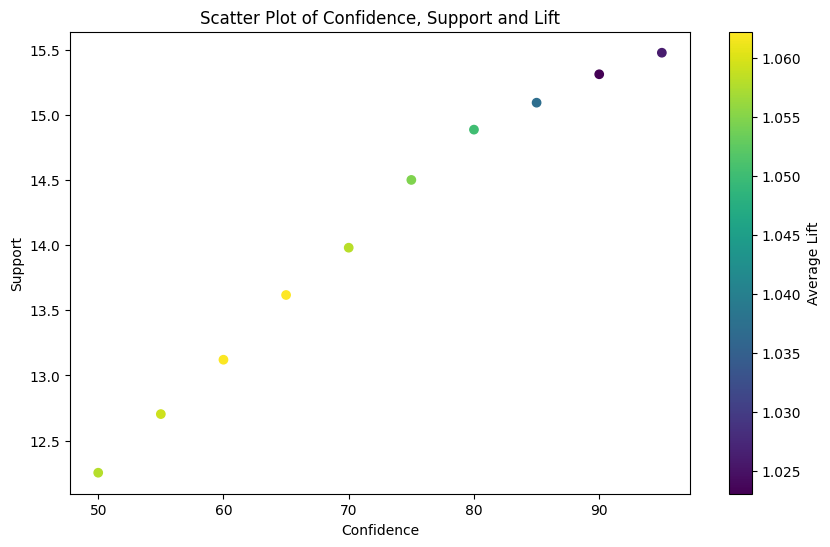

In [ ]:
# Extract confidence, support and lift values from the results
conf_values = [conf for conf in results.keys()]
avg_lift_values = [avg_lift for avg_lift in avg_lifts.values()]
supp_values = [results[conf]['%_support'].mean() for conf in results.keys()]

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a scatter plot
scatter = plt.scatter(conf_values, supp_values, c=avg_lift_values, cmap='viridis')

# Add a colorbar
plt.colorbar(scatter, label='Average Lift')

# Set the labels for the x and y axes
plt.xlabel('Confidence')
plt.ylabel('Support')

# Set the title of the plot
plt.title('Scatter Plot of Confidence, Support and Lift')

# Display the plot
plt.show()

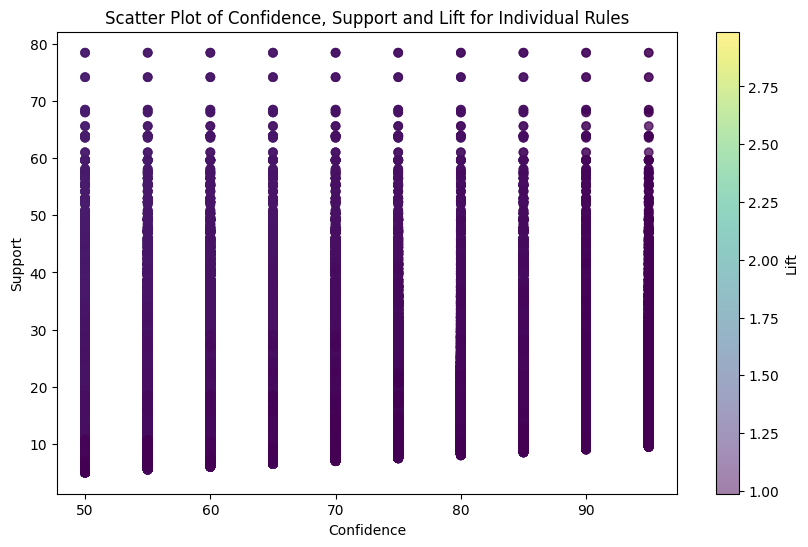

In [ ]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the results
for conf, rules_df in results.items():
    # Create a scatter plot for each set of rules
    plt.scatter([conf]*len(rules_df), rules_df['%_support'], c=rules_df['lift'], cmap='viridis', alpha=0.5)

# Add a colorbar
plt.colorbar(label='Lift')

# Set the labels for the x and y axes
plt.xlabel('Confidence')
plt.ylabel('Support')

# Set the title of the plot
plt.title('Scatter Plot of Confidence, Support and Lift for Individual Rules')

# Display the plot
plt.show()

In [ ]:
%%time
# 5min

len_r = []

min_sup = 10
max_sup = 45
min_conf = 50
max_conf = 95

for i in tqdm(range(min_sup, max_sup)):  # support
    len_r_wrt_i = []
    for j in range(min_conf, max_conf):  # confidence
        rules = apriori(X, target="r", supp=i, zmin=zmin, conf=j, report="aScl")
        len_r_wrt_i.append(len(rules))  # study your characteristics/properties here

    len_r.append(len_r_wrt_i)
len_r = np.array(len_r)

  0%|          | 0/35 [00:00<?, ?it/s]

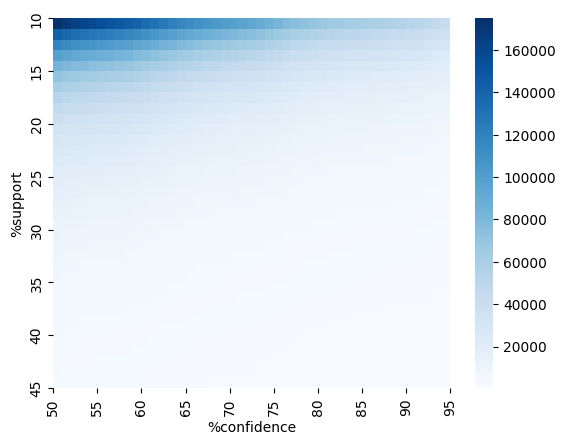

CPU times: user 444 ms, sys: 102 ms, total: 546 ms
Wall time: 497 ms


In [ ]:
sns.heatmap(len_r, cmap="Blues", fmt='g')
plt.yticks(np.arange(0, max_sup-min_sup +1, 5), np.arange(min_sup, max_sup+1,5 ))
plt.xticks(np.arange(0, max_conf-min_conf+1, 5), np.arange(min_conf, max_conf+1, 5))
plt.xlabel("%confidence")
plt.ylabel("%support")
plt.show()

## FP-Growth

In [ ]:
help(fpgrowth)

In [ ]:
%%time
#7sec

# Define the parameter grid
supp_values = np.linspace(10, 50, 5)
zmin_values = np.arange(5, df_pm.shape[1])

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=["supp", "zmin", "num_frequent_itemsets",
                                "num_closed_itemsets", "num_maximal_itemsets"])

# Loop over the parameter grid
for supp in tqdm(supp_values):
    for zmin in zmin_values:
        # Run FPGROWTH for each type of itemset
        frequent_itemsets = fpgrowth(X, target="s", supp=supp, zmin=zmin, report="S")
        closed_itemsets = fpgrowth(X, target="c", supp=supp, zmin=zmin, report="S")
        maximal_itemsets = fpgrowth(X, target="m", supp=supp, zmin=zmin, report="S")

        # Compute some evaluation metric (in this case, the number of itemsets)
        num_frequent = len(frequent_itemsets)
        num_closed = len(closed_itemsets)
        num_maximal = len(maximal_itemsets)

        # Store the results
        results = pd.concat([results, pd.DataFrame([{"supp": supp, "zmin": zmin, "num_frequent_itemsets": num_frequent,
                                                     "num_closed_itemsets": num_closed, "num_maximal_itemsets": num_maximal}])],
                            ignore_index=True)

# Sort the results based on some criteria
results = results.sort_values(by=["num_frequent_itemsets", "num_closed_itemsets", "num_maximal_itemsets"], ascending=False)

# Print the best parameters
best_parameters = results.iloc[0]
print(f"Best parameters: supp={best_parameters['supp']}, zmin={best_parameters['zmin']}")

  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters: supp=10.0, zmin=5
CPU times: user 4.78 s, sys: 25 ms, total: 4.81 s
Wall time: 4.82 s


In [ ]:
supp = best_parameters['supp']
zmin = best_parameters['zmin']

itemsets = fpgrowth(X, target="s", supp=supp, zmin=zmin, report="S")
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

,frequent_itemset,support
0,"(High_loudness, Non-Explicit, Low_speechiness,...",78.400000
1,"(Low_liveness, Non-Explicit, Low_speechiness, ...",74.126667
2,"(Low_liveness, High_loudness, Low_speechiness,...",67.973333
3,"(Low_liveness, High_loudness, Non-Explicit, Lo...",65.580000
4,"(Low_liveness, High_loudness, Non-Explicit, Lo...",63.860000
...,...,...
18880,"(C, Non-Explicit, Low_speechiness, High_proces...",10.840000
18881,"(C, Non-Explicit, Low_speechiness, High_proces...",10.840000
18882,"(C, Non-Explicit, Low_speechiness, High_proces...",10.840000
18883,"(C, Non-Explicit, Low_speechiness, Low_duratio...",10.840000


In [ ]:
# Define the range of confidence values to test
conf_values = range(50, 100, 5)

# Initialize a dictionary to store the results
results = {}

# Loop over the confidence values
for conf in tqdm(conf_values):
    # Run the apriori algorithm
    rules = fpgrowth(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")

    # Convert the rules to a DataFrame
    rules_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )

    # Sort the rules by lift
    rules_df = rules_df.sort_values(by="lift", axis=0, ascending=False)

    # Store the rules DataFrame in the results dictionary
    results[conf] = rules_df

# Now, 'results' is a dictionary where the keys are confidence values and the values are the corresponding rules DataFrames
avg_lifts = {}

# Loop over the results
for conf, rules_df in results.items():
    # Calculate the average lift for this confidence level
    avg_lift = rules_df['lift'].mean()

    # Store the average lift in the dictionary
    avg_lifts[conf] = avg_lift

# Find the confidence level with the highest average lift
best_conf = max(avg_lifts, key=avg_lifts.get)

print(f"The best value for conf is {best_conf} with an average lift of {avg_lifts[best_conf]}")

  0%|          | 0/10 [00:00<?, ?it/s]

The best value for conf is 65 with an average lift of 1.0621847787033813


In [ ]:
conf = best_conf
rules = fpgrowth(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")
pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
).sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
112967,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1112,7.413333,0.720674,5.118423
112968,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1111,7.406667,0.720493,5.117137
112969,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1111,7.406667,0.720026,5.113820
112970,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1113,7.420000,0.719922,5.113085
112957,Low_energy,"(High_acousticness, Low_valence, Low_liveness,...",1114,7.426667,0.719638,5.111067
...,...,...,...,...,...,...
98277,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1394,9.293333,0.654460,0.751677
98285,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1374,9.160000,0.653042,0.750048
98279,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1373,9.153333,0.652877,0.749859
98281,High_loudness,"(High_instrumentalness, Major, Low_liveness, L...",1373,9.153333,0.652877,0.749859


## Classification

In [ ]:
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)

rules_df['consequent'].unique()

array(['Low_n_bars', 'Low_duration_min', 'Low_speechiness',
       'Non-Explicit', 'High_loudness', 'Low_liveness', 'Medium_tempo',
       'Low_instrumentalness', 'Major', 'Low_acousticness',
       'Low_popularity', 'High_energy', 'Medium_danceability',
       'Low_processing', 'High_danceability', 'Low_valence',
       'High_acousticness', 'Low_energy', 'High_processing',
       'High_instrumentalness'], dtype=object)

In [ ]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   explicit          15000 non-null  object
 1   popularity        15000 non-null  object
 2   danceability      15000 non-null  object
 3   energy            15000 non-null  object
 4   key               15000 non-null  object
 5   loudness          15000 non-null  object
 6   mode              15000 non-null  object
 7   speechiness       15000 non-null  object
 8   acousticness      15000 non-null  object
 9   instrumentalness  15000 non-null  object
 10  liveness          15000 non-null  object
 11  valence           15000 non-null  object
 12  tempo             15000 non-null  object
 13  n_bars            15000 non-null  object
 14  processing        15000 non-null  object
 15  genre             15000 non-null  object
 16  duration_min      15000 non-null  object
dtypes: object(17

In [ ]:
for exp in df_pm['explicit'].unique():
  print(f"Ex/NonEx: {exp} -> {len(rules_df[rules_df['consequent'] == exp])} rules")

Ex/NonEx: Non-Explicit -> 11693 rules
Ex/NonEx: Explicit -> 0 rules


In [ ]:
for key in df_pm['key'].unique():
  print(f"Key: {key} -> {len(rules_df[rules_df['consequent'] == key])} rules")

Key: F -> 0 rules
Key: C#/Db -> 0 rules
Key: D -> 0 rules
Key: G -> 0 rules
Key: E -> 0 rules
Key: F#/Gb -> 0 rules
Key: A -> 0 rules
Key: G#/Ab -> 0 rules
Key: C -> 0 rules
Key: A#/Bb -> 0 rules
Key: D#/Eb -> 0 rules
Key: B -> 0 rules


In [ ]:
for genre in df_pm['genre'].unique():
  print(f"Genre: {genre} -> {len(rules_df[rules_df['consequent'] == genre])} rules")

In [ ]:
for mode in df_pm['mode'].unique():
  print(f"Mode: {mode} -> {len(rules_df[rules_df['consequent'] == mode])} rules")

Mode: Major -> 3500 rules
Mode: Minor -> 0 rules


In [ ]:
# Define the targets and labels
targets_cont = [
    'popularity', 'danceability', 'energy',
    'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence'
]
labels = ["Low", "Medium", "High"]

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Target', 'Label', 'Number of Rules'])

# Loop over each target and label
for target in targets_cont:
    for label in labels:
        # Calculate the number of rules
        num_rules = len(rules_df[rules_df['consequent'] == f'{label}_{target}'])

        # Create a temporary DataFrame to hold the current row
        temp_df = pd.DataFrame({'Target': [target], 'Label': [label], 'Number of Rules': [num_rules]})

        # Append the results to the DataFrame
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df

,Target,Label,Number of Rules
0,popularity,Low,3976
1,popularity,Medium,0
2,popularity,High,0
3,danceability,Low,0
4,danceability,Medium,732
5,danceability,High,133
6,energy,Low,31
7,energy,Medium,0
8,energy,High,6092
9,loudness,Low,0


Here’s a detailed explanation of the code:

conf = best_conf: This line sets the confidence threshold for the rules to be generated. The best_conf variable is not defined in this snippet, so it must have been defined earlier in the code.

rules = fpgrowth(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl"): This line calls the FP-Growth algorithm on the dataset X with the specified support (supp), minimum itemset size (zmin), and confidence (conf). The target parameter is set to "r", which means that the algorithm will generate rules. The report parameter is set to "aScl", which means that the algorithm will return the antecedent, support, confidence, and lift of each rule.

The next block of code creates a pandas DataFrame from the rules, with columns for the consequent and antecedent of each rule, the absolute support, the percentage support, the confidence, and the lift. It then sorts the DataFrame by lift in descending order.

rules_df = pd.DataFrame(...): This line creates a new DataFrame with the same structure as the previous one, but it doesn’t sort the rules.

The targets list contains the names of the features that the rules will be generated for.

The labels list contains the labels for the discretization of the features.

The final block of code loops over each target feature and each label, and prints the number of rules where the consequent is the label for that feature.

From the output, it seems like the algorithm has generated a significant number of rules for certain classes (like low popularity, high energy, high loudness, low speechiness, etc.), but no rules for other classes (like medium or high popularity, low or medium energy, etc.). This could indicate that the data is heavily skewed towards certain classes, as it was seen in data understanding phase.